In [3]:
!git clone https://github.com/hpt1988/Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course

Cloning into 'Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course'...
remote: Enumerating objects: 22230, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 22230 (delta 137), reused 275 (delta 127), pack-reused 21905
Receiving objects: 100% (22230/22230), 318.25 MiB | 20.30 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Checking out files: 100% (21952/21952), done.


In [4]:
!ls Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course/behavioural_cloning/Data

driving_log.csv  IMG


# Preprocessing

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [6]:
datadir = 'Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course/behavioural_cloning/Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_154.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_154.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_154.jpg,0.0,0.0,0.0,0.000081
1,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_264.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_264.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_264.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_375.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_375.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_375.jpg,0.0,0.0,0.0,0.000080
3,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_489.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_489.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_489.jpg,0.0,0.0,0.0,0.000079
4,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_596.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_596.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_596.jpg,0.0,0.0,0.0,0.000079


In [7]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_06_29_11_07_08_154.jpg,left_2021_06_29_11_07_08_154.jpg,right_2021_06_29_11_07_08_154.jpg,0.0,0.0,0.0,0.000081
1,center_2021_06_29_11_07_08_264.jpg,left_2021_06_29_11_07_08_264.jpg,right_2021_06_29_11_07_08_264.jpg,0.0,0.0,0.0,0.000078
2,center_2021_06_29_11_07_08_375.jpg,left_2021_06_29_11_07_08_375.jpg,right_2021_06_29_11_07_08_375.jpg,0.0,0.0,0.0,0.000080
3,center_2021_06_29_11_07_08_489.jpg,left_2021_06_29_11_07_08_489.jpg,right_2021_06_29_11_07_08_489.jpg,0.0,0.0,0.0,0.000079
4,center_2021_06_29_11_07_08_596.jpg,left_2021_06_29_11_07_08_596.jpg,right_2021_06_29_11_07_08_596.jpg,0.0,0.0,0.0,0.000079


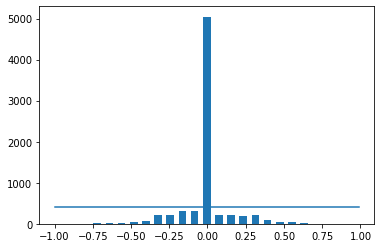

In [8]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  7300
removed:  4645
remaining:  2655


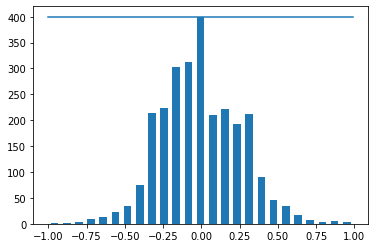

In [9]:
print('total data: ', len(data))
remove_list = []

for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [10]:
# Loading images as training data and corresponding steering angles as the label
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        # "iloc": allows to perform a selection on a row of data from data frame
        # based on thespecified index, which will simply be the current index
        # that's being iterated through. Therefore, "indexed_data" will contain
        # specific row of data at each iteration.
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        
        # "strip()" eliminates any spaces that may be present in the string
        # we only consider ceneter images for now
        image_path.append(os.path.join(datadir, center.strip()))

        steering.append(float(indexed_data[3]))

    image_paths = np.asarray(image_path)  # Convert list to array
    steerings = np.asarray(steering)  # Convert list to array
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

print(data.iloc[1])  # Illustration for "iloc"

center      center_2021_06_29_11_07_09_131.jpg
left        left_2021_06_29_11_07_09_131.jpg  
right       right_2021_06_29_11_07_09_131.jpg 
steering   -0.190757                          
throttle    0                                 
reverse     0                                 
speed       8.5504e-05                        
Name: 9, dtype: object


In [11]:
# Splitting the arrays to random training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 2124
Valid Samples: 531


Text(0.5, 1.0, 'Validation set')

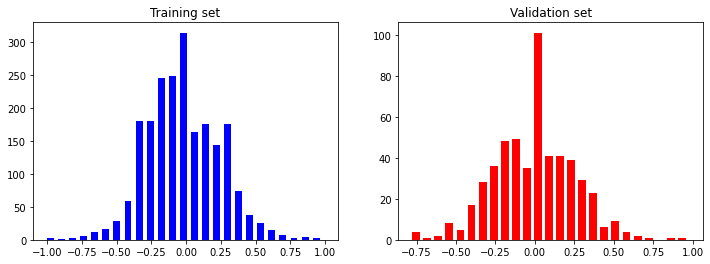

In [12]:
# To make sure both dataset (training and validation) include a uniform
# distribution of steering angles, such that both left and right steering angles
# are balanced, and model is a little bit more biased towards predicting 0 angle
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row and 2 columns
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [13]:
def img_preprocess(img):
    img = mpimg.imread(img)  # To read the image from the image path
    
    # Cropping unnecessary parts of the image like the car hood and sky and trees
    img = img[60:135, :, :]

    # Changing the color space of the image
    # Unlike the last course, here we don't use the LeNet architecture. Instead,
    # we use the Nvidia model. We use the YUV color-space instead of RGB or
    # grayscale here as it is recommended by Nvidia architects
    # YUV also consists of 3 channels:
    # Y: luminosity or brightness
    # UV: chrominance (adds color to the image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    # Addition of gaussian blur to smooth out and reduce noise within the image.
    # This helps to extract more features from images because it has to deal
    # with less noise.
    # It works by applying Gaussian kernel convolution on the image
    # cv2.GaussianBlur(InputImage, (KernelSize), KernelDeviation)
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Decreasing the image size to have faster computation
    # cv2.resize(InputImage, (OutputImageSize))
    # We used (200, 66) for the output image size as it matches the image size
    # of the input image used by Nvidia model architecture. It is not necessary,
    # but it helps us to remain consistance
    img = cv2.resize(img, (200, 66))

    # Normalization process
    img = img/255

    return img

Text(0.5, 1.0, 'Preprocessed Image')

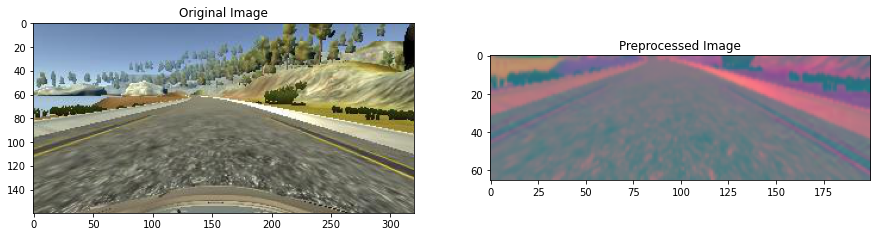

In [14]:
# Visualizing the original images alongside preprocessed images
image = image_paths[100]  # An arbitrary image
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [15]:
# Running the dataset through the preprocessing function

# map() function iterates through the entire array, and for every element of the
# array that it loop through returns a new element based on the specified
# function and ultimately creating a new array of updated values. It returns the
# elements in the format of a list
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(2124, 66, 200, 3)


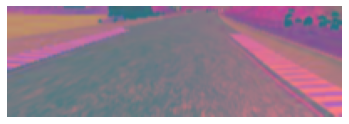

In [16]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

# Nvidia Model

As we have seen, the LeNet model was not effective in classifying traffic sign database, and only worked well with MNIST dataset. However, with behavioral cloning, the dataset is even more complex.

The image size are bigger, and the number of images are less. Furthermore, while our previous code, dealt with classification, here we deal with a regression type of example (predicting steering angle).

Therefore, we need a much more capable model, and a popular model used for behavioral cloning is called *Nvidia* model.

Download the article [here](https://arxiv.org/abs/1604.07316).

Model architecture:

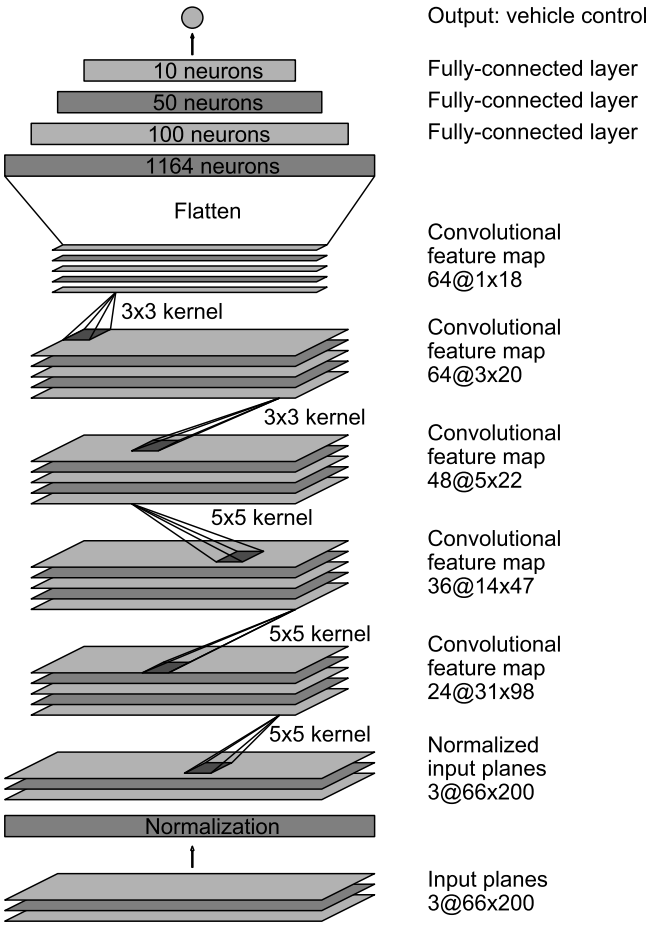

In [21]:
# Nvidia model
def nvidia_model():
    model = Sequential()

    # We skip the first layer of the above image, as we have already normalized
    # our data. So, we directly go to the convolutiona layer
    # It uses 24 filters with a size of 5x5 inside the convolutional filter.
    # strides refers to the stride length of our kernel. As we have larger
    # images here (comparing with previous courses), we increase it to (2, 2),
    # which means 2 pixels horizontal and vertical translations that results in
    # quicker computation
    # As edges of the image are not important, we don't use padding.
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))

    # 2nd convolutional layer
    # 36 layers with kernel size of (5, 5)
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))

    # 3rd to 5th convolutional layers
    # Due to the all of convolutions, the dimension of images have decreased
    # significantly. As a consequence, we remove the subsampling in the 4th and
    # 5th layers
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))

    # Ensure to not overfit using dropout layer
    model.add(Dropout(0.5))

    # Doing the math, the output of the above layers is of shape (1, 18, 64)
    # that is equal to 1152 pixels
    # Flattening
    model.add(Flatten())

    # Adding 3 dense fully connected layers and a dropout layer after the 1st
    # layer as it contains a large number of parameters.
    # To overcome the overfitting which was boserved later, 2 more dropout layer
    # added later.
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))

    # Dense layer with single output node that predicts the steering angle
    model.add(Dense(1))

    # Using a relatively low learning rate to improve accurace
    optimizer = Adam(learning_rate=1e-3)

    # Error metric is mean squared error, as it is a regression type example
    model.compile(loss='mse', optimizer=optimizer)

    return model

In [22]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [23]:
# Model training
# Number of epchs is relatively high, but as we have less data, it's required
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
22/22 [==============================] - 2s 52ms/step - loss: 0.6708 - val_loss: 0.0573
Epoch 2/30
22/22 [==============================] - 1s 29ms/step - loss: 0.1054 - val_loss: 0.0530
Epoch 3/30
22/22 [==============================] - 1s 29ms/step - loss: 0.0739 - val_loss: 0.0483
Epoch 4/30
22/22 [==============================] - 1s 28ms/step - loss: 0.0686 - val_loss: 0.0449
Epoch 5/30
22/22 [==============================] - 1s 28ms/step - loss: 0.0663 - val_loss: 0.0430
Epoch 6/30
22/22 [==============================] - 1s 28ms/step - loss: 0.0613 - val_loss: 0.0419
Epoch 7/30
22/22 [==============================] - 1s 29ms/step - loss: 0.0564 - val_loss: 0.0404
Epoch 8/30
22/22 [==============================] - 1s 28ms/step - loss: 0.0546 - val_loss: 0.0392
Epoch 9/30
22/22 [==============================] - 1s 28ms/step - loss: 0.0556 - val_loss: 0.0381
Epoch 10/30
22/22 [==============================] - 1s 28ms/step - loss: 0.0533 - val_loss: 0.0386
Epoch 11/

Text(0.5, 0, 'Epoch')

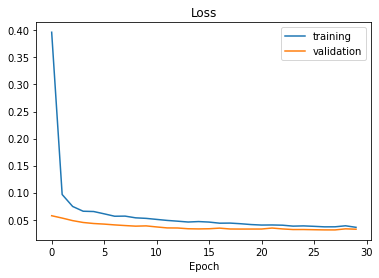

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Using the *relu* activation function, we got bad results (specially in the course video), which is called ***dead relu***.

This happens when a node in neural network essentially dies, and only feeds the value of 0 to the node that follows it. It is clearly discribed in the video.

Using *relu*:

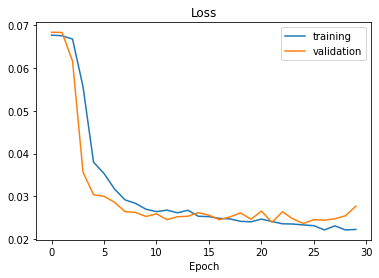


We will overcome this issue, by replacing the *relu* activation function with ***elu*** activation function.

Using *elu*:

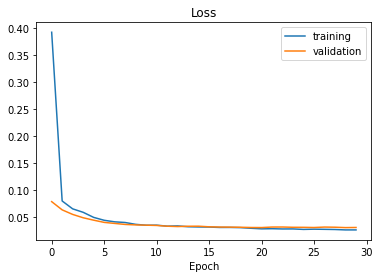

We still can see overfitting. In order to overcome this issue, we add two more dropout layers to our model. This leads to the following resutls:

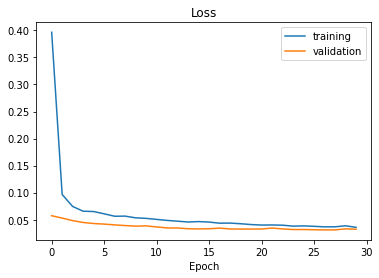

In [25]:
# Saving our model
model.save('model.h5')

In [26]:
# Downloading the model
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>